<a href="https://colab.research.google.com/github/Abhishek-Iyer1/emotion-classifcation-eeg/blob/main/code-v1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 

In [2]:
mat_file = sio.loadmat('ADD YOUR PATH HERE')
mat_file_labels = sio.loadmat('ADD YOUR PATH HERE')
count = 0
accuracy = []

In [3]:
data = mat_file['data']
labels = mat_file_labels['label']

labels = labels[0]
labels_edited = np.empty(675)
for i in range(0,45):
  labels_edited[i*15:(i+1)*15] = labels

data, labels_edited = shuffle(data, labels_edited)

In [4]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)

#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:550]
test_labels = labels_edited[550:600]
train_data = data[0:550]
test_data = data[550:600]
final_test = data[600:675]
final_labels = labels_edited[600:675]
cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the format for confusion matrix

train_labels_reshaped = train_labels.reshape(-1,1) #Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1,1)
final_labels_reshaped = final_labels.reshape(-1,1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 3) #One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 3)
final_labels_reshaped = to_categorical(final_labels_reshaped, 3)

rnn_train = train_data.reshape(550, 62, -1) #Formatting for CNN input
rnn_test = test_data.reshape(50, 62, -1)
rnn_train = np.transpose(rnn_train, (0,2,1))
rnn_test = np.transpose(rnn_test, (0,2,1))

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization

#Defining our CNN Model 

model = Sequential([
  Conv2D(filters= 64, kernel_size= 5, input_shape = (62,265,5), padding= 'same'), 
  MaxPooling2D(pool_size= 2,strides = 2),
  BatchNormalization(),

  Conv2D(filters= 128, kernel_size= 3, padding= 'same'), 
  MaxPooling2D(pool_size= 2, strides = 2),
  BatchNormalization(),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), 
  MaxPooling2D(pool_size= 2, strides = 2),
  BatchNormalization(),
  
  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides= 2),
  BatchNormalization(),
  
  Flatten(),

  Dense(512, activation= 'relu'), 
  BatchNormalization(),
  Dense(256, activation= 'relu'),
  BatchNormalization(),
  Dense(64, activation= 'relu'),
  BatchNormalization(),
  Dense(3, activation= 'softmax')
])

model.compile(optimizer= keras.optimizers.Adam(learning_rate=9e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 62, 265, 64)       8064      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 31, 132, 64)       0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 31, 132, 64)       256       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 31, 132, 128)      73856     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 15, 66, 128)       0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 15, 66, 128)       512       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 15, 66, 256)     

In [141]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape

#Defining our RNN model 

model_rnn = Sequential([
  LSTM(units= 128, activation= 'tanh', input_shape= [1325, 62], return_sequences = True),
  Dropout(0.25),
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  Dropout(0.3),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  Dropout(0.35),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  Flatten(),

  Dense(512, activation= 'relu'),
  Dropout(0.25),
  Dense(256, activation= 'relu'),
  Dropout(0.35),
  Dense(64, activation= 'relu'),
  Dense(3, activation= 'softmax'),

])

model_rnn.compile(optimizer= keras.optimizers.Adam(learning_rate=5e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model_rnn.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 1325, 128)         97792     
_________________________________________________________________
dropout_34 (Dropout)         (None, 1325, 128)         0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 1325, 128)         131584    
_________________________________________________________________
dropout_35 (Dropout)         (None, 1325, 128)         0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 1325, 256)         394240    
_________________________________________________________________
dropout_36 (Dropout)         (None, 1325, 256)         0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 1325, 256)       

In [94]:
#Defining our Hybrid model 

model_hybrid = Sequential([
  Conv2D(filters= 64, kernel_size= 3, input_shape = (62,265,5), padding= 'same'), 
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  BatchNormalization(),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), 
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  BatchNormalization(),

  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), 
  BatchNormalization(),

  Reshape((66, 15*512), input_shape= (15, 66, 512)), #Important to reshape so data passed to LSTM Layer correctly
  
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 512, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  
  Flatten(),
  
  Dense(512, activation= 'relu'), 
  Dropout(0.25), 
  Dense(256, activation= 'relu'),
  Dropout(0.2),
  Dense(64, activation= 'relu'),
  Dense(3, activation= 'softmax')
])

model_hybrid.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model_hybrid.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 62, 265, 64)       2944      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 62, 265, 128)      73856     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 62, 265, 128)      147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 132, 128)      0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 31, 132, 128)      512       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 31, 132, 256)      295168    
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 31, 132, 256)    

In [174]:
#Training our CNN model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7) 

history = model.fit(
  train_data,
  train_labels_reshaped,
  batch_size = 64,
  epochs=50, 
  validation_data=(test_data, test_labels_reshaped),
  callbacks = [reduce_lr_cnn]
)

Epoch 1/50
9/9 [==============================] - 2s 128ms/step - loss: 1.0238 - accuracy: 0.5795 - root_mean_squared_error: 0.4290 - val_loss: 0.9561 - val_accuracy: 0.5400 - val_root_mean_squared_error: 0.4380
Epoch 2/50
9/9 [==============================] - 1s 96ms/step - loss: 0.3319 - accuracy: 0.8485 - root_mean_squared_error: 0.2601 - val_loss: 0.8712 - val_accuracy: 0.6800 - val_root_mean_squared_error: 0.4133
Epoch 3/50
9/9 [==============================] - 1s 95ms/step - loss: 0.2206 - accuracy: 0.9139 - root_mean_squared_error: 0.2049 - val_loss: 0.8132 - val_accuracy: 0.8200 - val_root_mean_squared_error: 0.3954
Epoch 4/50
9/9 [==============================] - 1s 95ms/step - loss: 0.1706 - accuracy: 0.9528 - root_mean_squared_error: 0.1738 - val_loss: 0.8087 - val_accuracy: 0.7600 - val_root_mean_squared_error: 0.3951
Epoch 5/50
9/9 [==============================] - 1s 96ms/step - loss: 0.1267 - accuracy: 0.9560 - root_mean_squared_error: 0.1459 - val_loss: 0.8292 - val

In [142]:
#Training our RNN model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6) 
history_rnn = model_rnn.fit(
  rnn_train,
  train_labels_reshaped,
  batch_size = 64,
  epochs=60,
  validation_data=(rnn_test, test_labels_reshaped),
  callbacks = [reduce_lr_rnn]
)

Epoch 1/60
9/9 [==============================] - 10s 583ms/step - loss: 1.1274 - accuracy: 0.3670 - root_mean_squared_error: 0.4777 - val_loss: 1.0968 - val_accuracy: 0.3600 - val_root_mean_squared_error: 0.4672
Epoch 2/60
9/9 [==============================] - 4s 450ms/step - loss: 0.9927 - accuracy: 0.4969 - root_mean_squared_error: 0.4452 - val_loss: 0.9464 - val_accuracy: 0.6400 - val_root_mean_squared_error: 0.4319
Epoch 3/60
9/9 [==============================] - 4s 448ms/step - loss: 0.9062 - accuracy: 0.5791 - root_mean_squared_error: 0.4239 - val_loss: 0.7209 - val_accuracy: 0.6400 - val_root_mean_squared_error: 0.3750
Epoch 4/60
9/9 [==============================] - 4s 450ms/step - loss: 0.7508 - accuracy: 0.6368 - root_mean_squared_error: 0.3847 - val_loss: 0.6351 - val_accuracy: 0.6800 - val_root_mean_squared_error: 0.3544
Epoch 5/60
9/9 [==============================] - 4s 453ms/step - loss: 0.6722 - accuracy: 0.6660 - root_mean_squared_error: 0.3628 - val_loss: 0.6645 

In [95]:
#Training our Hybrid model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_hybrid = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6) 

history_hybrid = model_hybrid.fit(
  train_data,
  train_labels_reshaped,
  batch_size = 32,
  epochs=60,
  validation_data=(test_data, test_labels_reshaped),
  callbacks = [reduce_lr_hybrid]
)

Epoch 1/60
18/18 [==============================] - 11s 340ms/step - loss: 1.0864 - accuracy: 0.5446 - root_mean_squared_error: 0.4532 - val_loss: 1.0998 - val_accuracy: 0.2600 - val_root_mean_squared_error: 0.4716
Epoch 2/60
18/18 [==============================] - 5s 273ms/step - loss: 0.6589 - accuracy: 0.7200 - root_mean_squared_error: 0.3552 - val_loss: 1.0666 - val_accuracy: 0.5200 - val_root_mean_squared_error: 0.4636
Epoch 3/60
18/18 [==============================] - 5s 274ms/step - loss: 0.5724 - accuracy: 0.7669 - root_mean_squared_error: 0.3312 - val_loss: 1.0441 - val_accuracy: 0.4800 - val_root_mean_squared_error: 0.4584
Epoch 4/60
18/18 [==============================] - 5s 275ms/step - loss: 0.6001 - accuracy: 0.7674 - root_mean_squared_error: 0.3328 - val_loss: 1.0216 - val_accuracy: 0.4600 - val_root_mean_squared_error: 0.4531
Epoch 5/60
18/18 [==============================] - 5s 276ms/step - loss: 0.5308 - accuracy: 0.8002 - root_mean_squared_error: 0.3099 - val_los

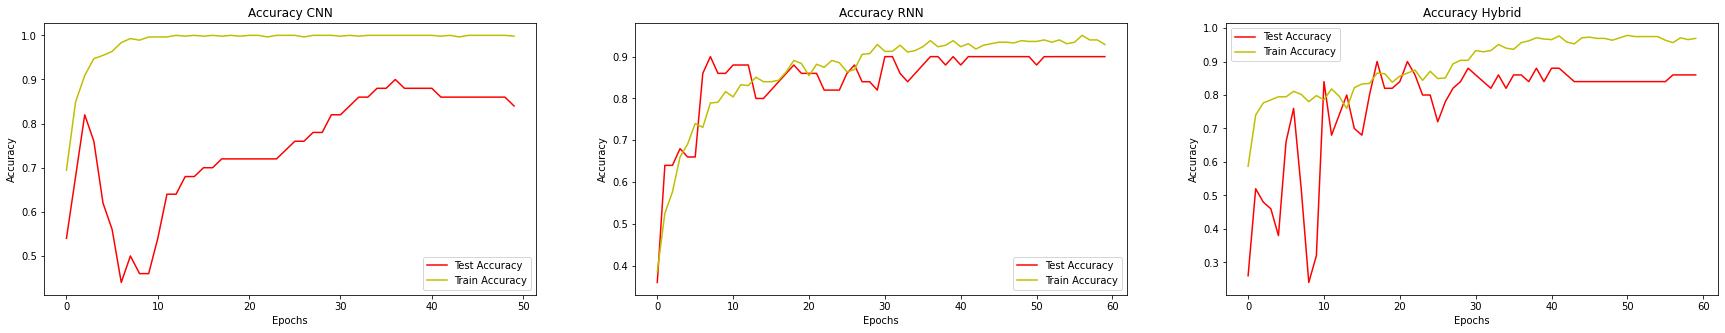

In [175]:
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])
epochs_rnn = len(history_rnn.history['accuracy'])
epochs_hybrid = len(history_hybrid.history['accuracy'])

plt.rcParams["figure.figsize"] = (30,5)
fig, a = plt.subplots(1, 3, squeeze= False)

a[0][0].plot(range(0,epochs), history.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs), history.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy CNN')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Accuracy')
a[0][0].legend()

a[0][1].plot(range(0,epochs_rnn), history_rnn.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][1].plot(range(0,epochs_rnn), history_rnn.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][1].set_title('Accuracy RNN')
a[0][1].set_xlabel('Epochs')
a[0][1].set_ylabel('Accuracy')
a[0][1].legend()

a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][2].set_title('Accuracy Hybrid')
a[0][2].set_xlabel('Epochs')
a[0][2].set_ylabel('Accuracy')
a[0][2].legend()

plt.show()

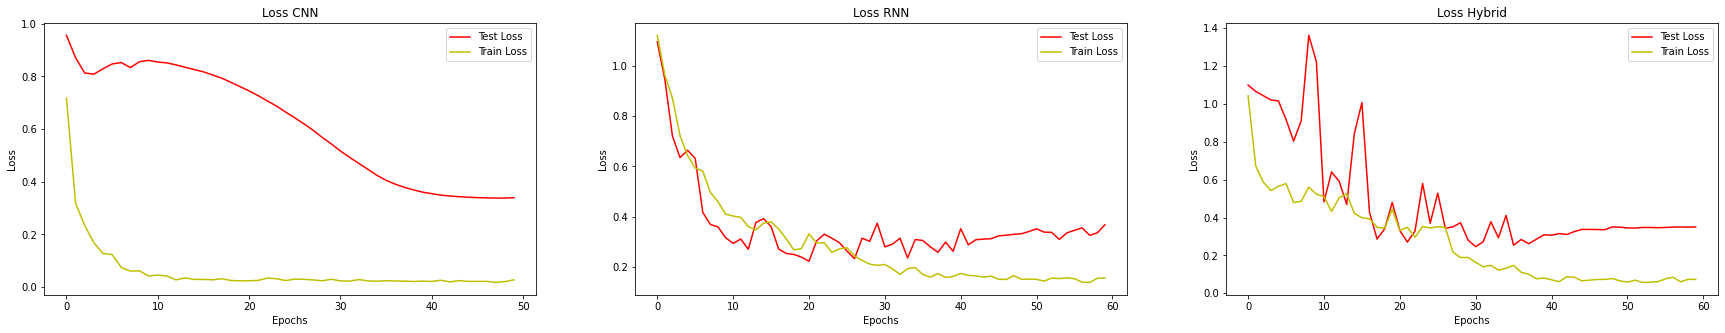

In [176]:
plt.rcParams["figure.figsize"] = (30,5)
fig, a = plt.subplots(1, 3, squeeze= False)

a[0][0].plot(range(0,epochs), history.history['val_loss'], 'r', label = 'Test Loss')
a[0][0].plot(range(0,epochs), history.history['loss'], 'y', label = 'Train Loss')
a[0][0].set_title('Loss CNN')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Loss')
a[0][0].legend()

a[0][1].plot(range(0,epochs_rnn), history_rnn.history['val_loss'], 'r', label = 'Test Loss')
a[0][1].plot(range(0,epochs_rnn), history_rnn.history['loss'], 'y', label = 'Train Loss')
a[0][1].set_title('Loss RNN')
a[0][1].set_xlabel('Epochs')
a[0][1].set_ylabel('Loss')
a[0][1].legend()

a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['val_loss'], 'r', label = 'Test Loss')
a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['loss'], 'y', label = 'Train Loss')
a[0][2].set_title('Loss Hybrid')
a[0][2].set_xlabel('Epochs')
a[0][2].set_ylabel('Loss')
a[0][2].legend()

plt.show()

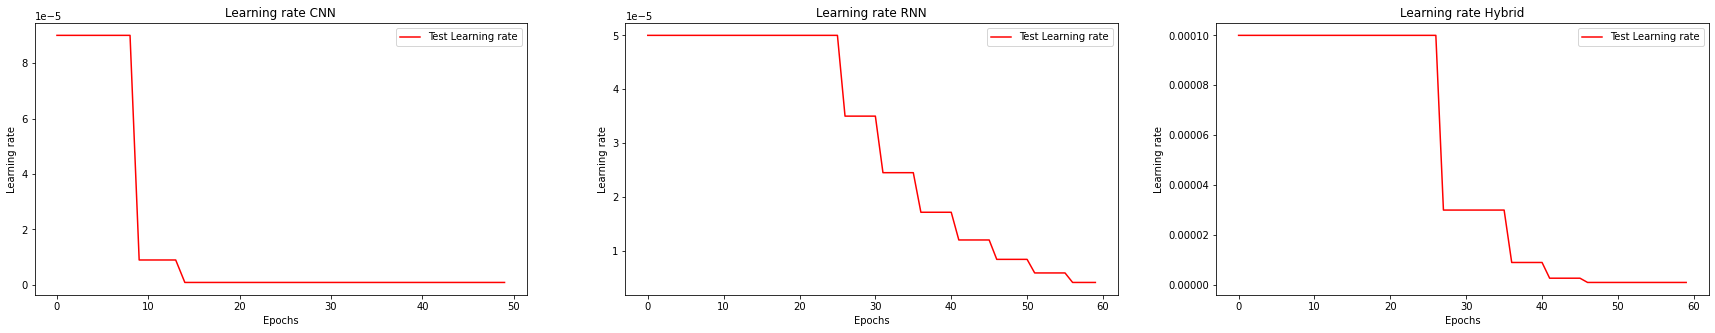

In [177]:
plt.rcParams["figure.figsize"] = (30,5)
fig, a = plt.subplots(1, 3, squeeze= False)

a[0][0].plot(range(0,epochs), history.history['lr'], 'r', label = 'Test Learning rate')
a[0][0].set_title('Learning rate CNN')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Learning rate')
a[0][0].legend()

a[0][1].plot(range(0,epochs_rnn), history_rnn.history['lr'], 'r', label = 'Test Learning rate')
a[0][1].set_title('Learning rate RNN')
a[0][1].set_xlabel('Epochs')
a[0][1].set_ylabel('Learning rate')
a[0][1].legend()

a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['lr'], 'r', label = 'Test Learning rate')
a[0][2].set_title('Learning rate Hybrid')
a[0][2].set_xlabel('Epochs')
a[0][2].set_ylabel('Learning rate')
a[0][2].legend()
plt.show()

In [178]:
#Calculating Metrics, Confusion Matrices and Classification Reports
his = model.evaluate(x= final_test, y = final_labels_reshaped)
accuracy = his[1]
final_preds = np.empty([3, 75])
pred_labels = np.argmax(model.predict(final_test), axis=-1)

final_rnn_test = final_test.reshape(75, 62, -1)
final_rnn_test = np.transpose(final_rnn_test, (0,2,1))

his_rnn = model_rnn.evaluate(x= final_rnn_test, y = final_labels_reshaped)
accuracy_rnn = his_rnn[1]
pred_labels_rnn = np.argmax(model_rnn.predict(final_rnn_test), axis=-1)


his_hybrid = model_hybrid.evaluate(x= final_test, y = final_labels_reshaped)
accuracy_hybrid = his_hybrid[1]
pred_labels_hybrid = np.argmax(model_hybrid.predict(final_test), axis=-1)

final_preds[0,:] = pred_labels
final_preds[1,:] = pred_labels_rnn
final_preds[2,:] = pred_labels_hybrid

#Implementing Ensemble

ensemble_predictions = []
itr = 0
for i in range (0,75):
  itr += 1
  unique, counts = np.unique(final_preds[:,i], return_counts=True)
  if len(unique) == 3:
    ensemble_predictions.append(int(final_preds[2,i]))
  else:
    index = np.unravel_index(np.argmax(counts), counts.shape)
    pred = unique[index]
    ensemble_predictions.append(int(pred))

accuracy_ensemble = sklearn.metrics.accuracy_score(cf_labels, ensemble_predictions)
cf_cnn = sklearn.metrics.confusion_matrix(cf_labels, pred_labels, labels = [2,0,1])
cf_rnn = sklearn.metrics.confusion_matrix(cf_labels, pred_labels_rnn, labels = [2,0,1])
cf_hybrid = sklearn.metrics.confusion_matrix(cf_labels, pred_labels_hybrid, labels = [2,0,1])
cf_ensemble = sklearn.metrics.confusion_matrix(cf_labels, ensemble_predictions, labels = [2,0,1])
cf = sklearn.metrics.confusion_matrix(cf_labels, pred_labels, labels= [2,0,1])
cr = sklearn.metrics.classification_report(cf_labels, pred_labels, labels= [2,0,1])
cr_rnn = sklearn.metrics.classification_report(cf_labels, pred_labels_rnn, labels= [2,0,1])
cr_hybrid = sklearn.metrics.classification_report(cf_labels, pred_labels_hybrid, labels= [2,0,1])
cr_ensemble = sklearn.metrics.classification_report(cf_labels, ensemble_predictions, labels= [2,0,1])
print("\n", "Accuracy of CNN: " + str(accuracy), "Accuracy of RNN: " + str(accuracy_rnn), "Accuracy of Hybrid Model: " + str(accuracy_hybrid), "Accuracy Ensemble: " + str(accuracy_ensemble), "\n", "Confusion Matrix CNN: ", str(cf), "Confusion Matrix RNN: ", str(cf_rnn), "Confusion Matrix Hybrid: ", str(cf_hybrid), "Confusion Matrix Ensemble: ", str(cf_ensemble), "\n", "Classification Report CNN: ", str(cr), "Classification Report RNN: ", str(cr_rnn),  "Classification Report Hybrid: ", str(cr_hybrid), "Classification Report Ensemble: ", str(cr_ensemble), sep= '\n')

#Use below code to save model and weights permanently

"""
with open('/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy', 'wb') as f:
    np.save(f, data)
    np.save(f, train_data)
    np.save(f, test_data)
    np.save(f, final_test)
with open('/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    c = np.load(f)
    d = np.load(f)
print(np.testing.assert_allclose(d, final_test, err_msg= "FAIL"))

model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/cnn_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Colab Notebooks/cnn_best.h5")
print("Saved model to disk")

# load json and create model
json_file = open('/content/drive/MyDrive/Colab Notebooks/ensemble_best.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/ensemble_best.h5")
print("Loaded model from disk")

loaded_model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', 'categorical_accuracy', tf.keras.metrics.RootMeanSquaredError()])

"""

3/3 [==============================] - 0s 74ms/step - loss: 0.1416 - accuracy: 0.9333 - root_mean_squared_error: 0.1785


Accuracy of CNN: 0.8799999952316284
Accuracy of RNN: 0.8933333158493042
Accuracy of Hybrid Model: 0.9333333373069763
Accuracy Ensemble: 0.9733333333333334


Confusion Matrix CNN: 
[[26  0  0]
 [ 3 22  0]
 [ 4  2 18]]
Confusion Matrix RNN: 
[[22  0  4]
 [ 3 21  1]
 [ 0  0 24]]
Confusion Matrix Hybrid: 
[[24  0  2]
 [ 2 22  1]
 [ 0  0 24]]
Confusion Matrix Ensemble: 
[[26  0  0]
 [ 2 23  0]
 [ 0  0 24]]


Classification Report CNN: 
              precision    recall  f1-score   support

           2       0.79      1.00      0.88        26
           0       0.92      0.88      0.90        25
           1       1.00      0.75      0.86        24

    accuracy                           0.88        75
   macro avg       0.90      0.88      0.88        75
weighted avg       0.90      0.88      0.88        75

Classification Report RNN: 
              precision    recall 

'\nwith open(\'/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy\', \'wb\') as f:\n    np.save(f, data)\n    np.save(f, train_data)\n    np.save(f, test_data)\n    np.save(f, final_test)\nwith open(\'/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy\', \'rb\') as f:\n    a = np.load(f)\n    b = np.load(f)\n    c = np.load(f)\n    d = np.load(f)\nprint(np.testing.assert_allclose(d, final_test, err_msg= "FAIL"))\n\nmodel_json = model.to_json()\nwith open("/content/drive/MyDrive/Colab Notebooks/cnn_best.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("/content/drive/MyDrive/Colab Notebooks/cnn_best.h5")\nprint("Saved model to disk")\n\n# load json and create model\njson_file = open(\'/content/drive/MyDrive/Colab Notebooks/ensemble_best.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = tf.keras.models.model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model